In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy as sa 

%matplotlib inline

%config IPCompleter.greedy = True 


In [3]:
#creamos la conexión
con = sa.create_engine('sqlite:///../Datasets/airbnb.db')

df = pd.read_sql('df',con)

# Preparación de Variables

## Creación de kpis de palancas


Primero vamos a crear las variables de análisis, es decir las que habíamos identificado como los Kpis que usaremos en las palancas que influyen sobre el negocio.

Habíamos dicho que eran 3:

* precio por noche: esta ya la tenemos directamente en la variable price, pero vamos a revisarla para ver que la entendemos bien
* ocupación: tenemos availability_365 pero hay que transformarla
* precio del inmueble: esta tendremos que crearla con variables externas así que la dejamos para después

**Empezamos con el precio.**

La documentación no aclara si el precio es por todo el inmueble, o si en el caso de que se alquile una habitación es por habitación.

Es un dato clave para poder hacer la valoración de los potenciales ingresos de un inmueble.

Vamos a intentar entenderlo analizando el precio medio por tipo de alquiler.

Es importante filtrar por solo un distrito para no incluir el efecto "zona".

Así que primero elegimos un distrito que tenga muchos datos.

In [4]:
df.head(5)

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2,distrito
0,0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,60,...,t,2,1.0,1.0,80,4.87,4.89,4.77,5098,Chamartín
1,1,21853,Bright and airy room,83531,Latina,Cármenes,40.40381,-3.74130,Private room,31,...,f,1,1.0,1.0,33,4.58,4.82,4.21,2267,Latina
2,2,23001,Apartmento Arganzuela- Madrid Rio,82175,Arganzuela,Legazpi,40.38840,-3.69511,Entire home/apt,50,...,f,6,3.0,5.0,0,NaN,NaN,NaN,4085,Arganzuela
3,3,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.42183,-3.70529,Entire home/apt,92,...,f,3,1.0,1.0,12,4.92,5.00,5.00,4827,Centro
4,4,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.38975,-3.69018,Private room,26,...,f,1,1.0,1.0,149,4.68,4.71,4.70,4085,Arganzuela


In [5]:
df.distrito.value_counts()

Centro                   8127
Salamanca                1218
Chamberí                 1089
Arganzuela               1005
Tetuán                    762
Retiro                    618
Carabanchel               581
Chamartín                 538
Ciudad Lineal             532
Moncloa - Aravaca         493
Puente de Vallecas        465
San Blas - Canillejas     463
Latina                    455
Hortaleza                 354
Fuencarral - El Pardo     265
Usera                     233
Barajas                   142
Villaverde                129
Moratalaz                  94
Villa de Vallecas          90
Vicálvaro                  57
Name: distrito, dtype: int64

In [6]:
df[df.distrito == 'Centro'].groupby('room_type').price.mean()

room_type
Entire home/apt    148.859980
Private room        67.131643
Shared room         60.464286
Name: price, dtype: float64

Conclusión:
    
* alquilar el apartamento tiene un precio medio de 148€
* alquilar una habitación tiene un precio medio de 60€ o 67€ según sea compartida o privada
* por tanto para calcular los "ingresos" de un inmueble sí deberemos multiplicar el precio el precio por el número de habitaciones cuando sea de los tipos Private room o Shared room

Ahora bien, multiplicar el precio por el total de habitaciones puede sesgar artificialmente al alza la capacidad de generar ingresos de un inmueble.

Ya que si se alquila por habitaciones no es probable que siempre esté al 100%

Por tanto deberíamos ponderarlo por el porcentaje medio de habitaciones alquiladas.

No tenemos ese dato, pero supongamos que hemos hablado con el responsable de negocio y nos ha dicho que es del 70%.

Podemos crear la variable precio total aplicando apply sobre una función personalizada.

In [7]:
def crear_precio_total(registro):
    if (registro.beds > 1) & ((registro.room_type == 'Private room') | (registro.room_type == 'Shared room')):
        return registro.price * registro.beds * 0.7
    else:
        return registro.price

df['precio_total'] = df.apply(crear_precio_total, axis= 1)
df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2,distrito,precio_total
0,0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,60,...,2,1.0,1.0,80,4.87,4.89,4.77,5098,Chamartín,60.0
1,1,21853,Bright and airy room,83531,Latina,Cármenes,40.40381,-3.74130,Private room,31,...,1,1.0,1.0,33,4.58,4.82,4.21,2267,Latina,31.0
2,2,23001,Apartmento Arganzuela- Madrid Rio,82175,Arganzuela,Legazpi,40.38840,-3.69511,Entire home/apt,50,...,6,3.0,5.0,0,NaN,NaN,NaN,4085,Arganzuela,50.0
3,3,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.42183,-3.70529,Entire home/apt,92,...,3,1.0,1.0,12,4.92,5.00,5.00,4827,Centro,92.0
4,4,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.38975,-3.69018,Private room,26,...,1,1.0,1.0,149,4.68,4.71,4.70,4085,Arganzuela,26.0


In [8]:
df[['room_type','beds','price','precio_total']].head(30)

,room_type,beds,price,precio_total
0,Private room,1.0,60,60.0
1,Private room,1.0,31,31.0
2,Entire home/apt,5.0,50,50.0
3,Entire home/apt,1.0,92,92.0
4,Private room,1.0,26,26.0
...,...,...,...,...
25,Private room,1.0,55,55.0
26,Private room,2.0,26,36.4
27,Private room,2.0,31,43.4
28,Entire home/apt,1.0,60,60.0


**Ahora vamos con la ocupación**

La variable que tenemos que nos permite medir esto es availability_365.

Esta variable nos dice el número de días a un año vista que el inmueble NO está ocupado.

Por tanto nos interesaría transformarla a una medida más directa de ocupación, por ejemplo el % del año que SI está ocupada.

Podemos hacerlo con una tranformación directa.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17710 entries, 0 to 17709
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           17710 non-null  int64  
 1   id                              17710 non-null  int64  
 2   name                            17707 non-null  object 
 3   host_id                         17710 non-null  int64  
 4   neighbourhood_group             17710 non-null  object 
 5   neighbourhood                   17710 non-null  object 
 6   latitude                        17710 non-null  float64
 7   longitude                       17710 non-null  float64
 8   room_type                       17710 non-null  object 
 9   price                           17710 non-null  int64  
 10  minimum_nights                  17710 non-null  int64  
 11  calculated_host_listings_count  17710 non-null  int64  
 12  availability_365                

In [10]:
df.availability_365

0        180
1        364
2        222
3        115
4        349
        ... 
17705    358
17706    358
17707    358
17708    358
17709    358
Name: availability_365, Length: 17710, dtype: int64

In [11]:
df['ocupacion'] = (((365 - df.availability_365) / 365) * 100).astype('int64')
df[['ocupacion','availability_365']].head(10)

,ocupacion,availability_365
0,50,180
1,0,364
2,39,222
3,68,115
4,4,349
5,38,223
6,13,314
7,100,0
8,0,365
9,9,331


## Transformación de varaibles de análisis


Algunas de las preguntas semilla están dirigidas a comprobar cómo se comporta el precio o la ocupación según otras variables como el número de habitaciones, la media de valoraciones, etc.

Normalmente podremos hacer mejor estos análisis si discretizamos la variable de análisis.

En nuestro caso las candidatas para este análisis son: accommodates, bedrooms, beds y number_of_reviews.

En bedrooms tiene sentido una discretización más personalizada. En las otras podemos hacerla automática.

**Discretizar bedrooms**

Comenzamos por evaluar la distribución de los datos.

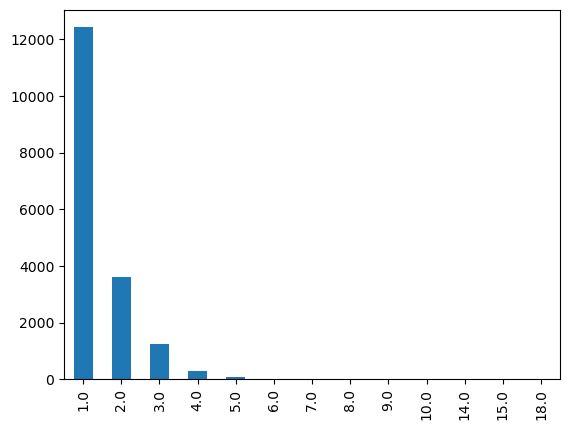

In [12]:
df.bedrooms.value_counts().plot.bar();

Vamos a discretizar para 1,2,3 y más de 3.

Podemos usar np.select

In [13]:
condiciones = [df.bedrooms == 1,
               df.bedrooms == 2,
               df.bedrooms == 3,
               df.bedrooms > 3]
resultados = ['01_Una','02_Dos','03_Tres','04_Cuatro_o_mas']

df['bedrooms_disc'] = np.select(condiciones,resultados,default= -999)


In [14]:
df.bedrooms_disc.value_counts()

01_Una             12422
02_Dos              3617
03_Tres             1228
04_Cuatro_o_mas      443
Name: bedrooms_disc, dtype: int64

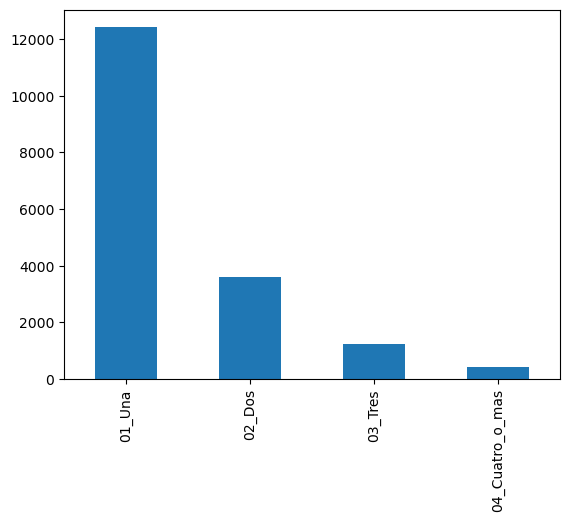

In [15]:
df.bedrooms_disc.value_counts().plot.bar();

**Discretizar accommodates, beds y number_of_reviews**

Vamos a usar qcut para discritizar con percentiles 0.5, 0.8, 1

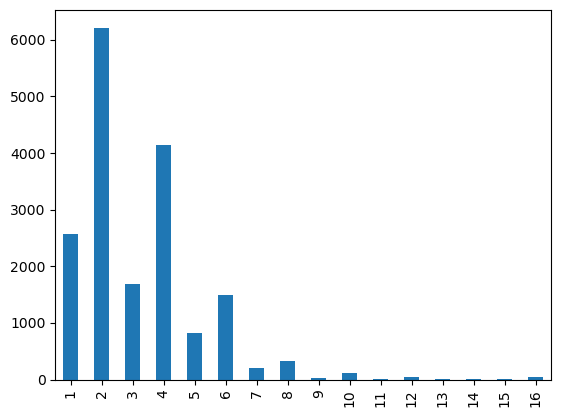

In [16]:
df.accommodates.value_counts().sort_index().plot.bar();

In [17]:
df.accommodates.describe().T

count    17710.000000
mean         3.200565
std          1.965390
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         16.000000
Name: accommodates, dtype: float64

<AxesSubplot:>

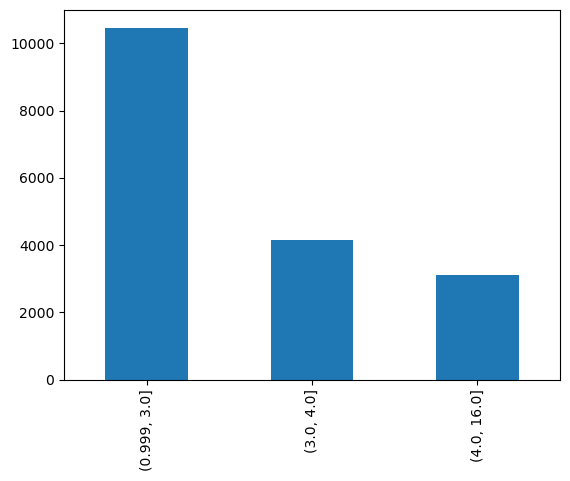

In [18]:
#creamos la discretización por cuartiles y mostramos el gráfico.
pd.qcut(df.accommodates, [0,0.5,0.8,1]).value_counts().plot.bar()

In [19]:
#Añádimos las etiquetas de accommodates
df['accommodates_disc'] = pd.qcut(df.accommodates, [0,0.5,0.8,1],
                                   labels= ['0-3','4','5-16'])


In [20]:
df.accommodates_disc.value_counts()

0-3     10472
4        4143
5-16     3095
Name: accommodates_disc, dtype: int64

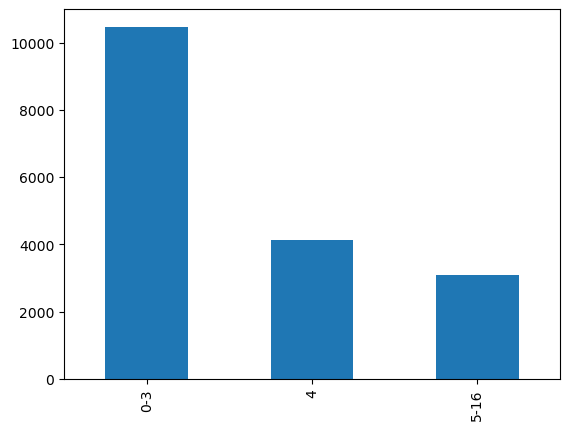

In [21]:
df.accommodates_disc.value_counts().plot.bar();

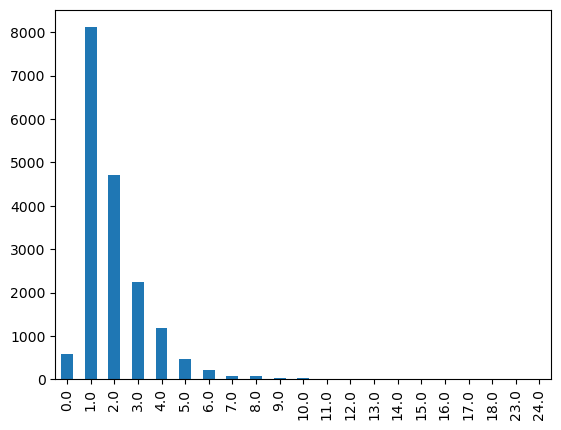

In [22]:
#Creamos variables discretizada beds_disc
df.beds.value_counts().sort_index().plot.bar();

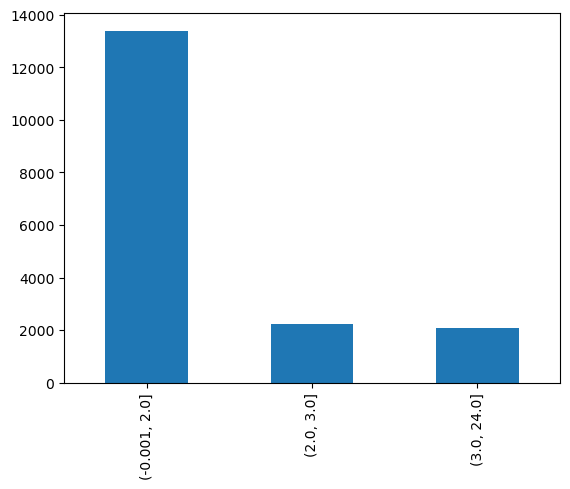

In [23]:

pd.qcut(df.beds, [0,0.5,0.8,1]).value_counts().plot.bar();

In [24]:
#Añádimos las etiquetas de beds
df['beds_disc'] = pd.qcut(df.beds, [0,0.5,0.8,1],
                                   labels= ['2','3','3-24'])

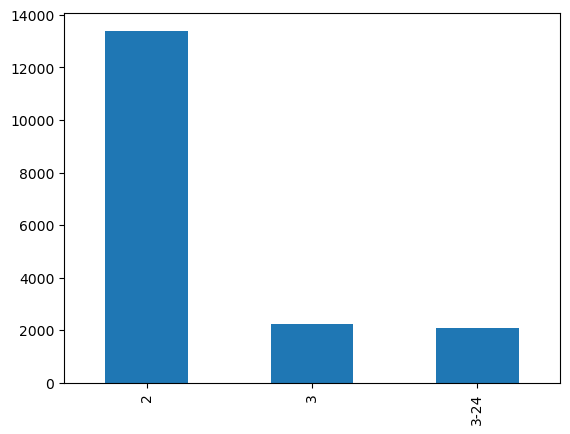

In [25]:
df.beds_disc.value_counts().plot.bar();

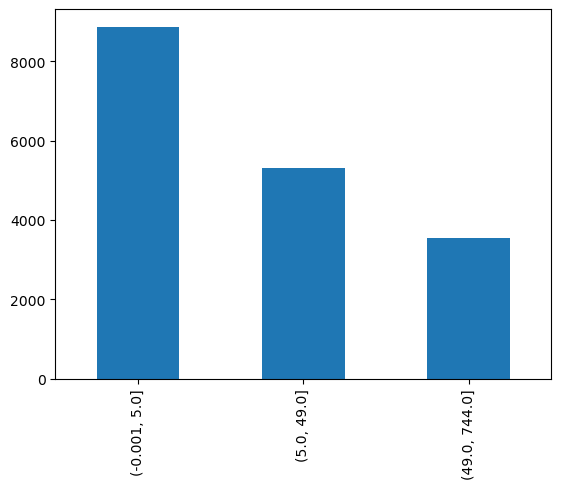

In [26]:
pd.qcut(df.number_of_reviews, [0,0.5,0.8,1]).value_counts().plot.bar();

In [27]:
#Añádimos las etiquetas de numbers of review
df['number_of_reviews_disc'] = pd.qcut(df.number_of_reviews, [0,0.5,0.8,1],
                                   labels= ['5','6-49','50-744'])

## Creación de variables con datos externos

En este caso en concreto se podrían hacer muchas cosas con datos externos.

Lo primero, que ya hemos incorporado parcialmente, es la palanca del precio del inmueble.

Decíamos que la podíamos estimar multiplicando los metros cuadrados del inmueble por el precio por m2.

El precio_m2 ya lo hemos conseguido, pero el tamaño del inmueble no lo tenemos en los datos.

Lo que podemos hacer es establecer unos criterios en base al número de habitaciones.

No es perfecto, pero nos servirá de aproximación.

**Estimación de los metros cuadrados del inmueble**

Vamos usar el siguiente algoritmo:

* una habitación: m2 = 50
* dos habitaciones: m2 = 70
* tres habitaciones: m2 = 90
* cuatro habitaciones: m2 = 120
* cinco o más habitaciones: m2 = 150

In [28]:
condiciones = [df.bedrooms == 1,
               df.bedrooms == 2,
               df.bedrooms == 3,
               df.bedrooms == 4,
               df.bedrooms > 4]
resultados = [50,70,90,120,150]

df['m2'] = np.select(condiciones,resultados, default= -999)

In [29]:
df['m2'].value_counts()

50     12422
70      3617
90      1228
120      296
150      147
Name: m2, dtype: int64

Ahora ya podemos estimar el precio de compra del inmueble.

Recordamos que al precio que nos sale le quitábamos un 30% por capacidad de negociación.

In [30]:
df['precio_compra'] = df.m2 * df.precio_m2 * 0.7

In [31]:
df[['bedrooms','m2','distrito','precio_m2','precio_compra']].head(20)

,bedrooms,m2,distrito,precio_m2,precio_compra
0,1.0,50,Chamartín,5098,178430.0
1,1.0,50,Latina,2267,79345.0
2,3.0,90,Arganzuela,4085,257355.0
3,1.0,50,Centro,4827,168945.0
4,1.0,50,Arganzuela,4085,142975.0
...,...,...,...,...,...
15,1.0,50,Centro,4827,168945.0
16,1.0,50,Centro,4827,168945.0
17,2.0,70,Centro,4827,236523.0
18,2.0,70,Centro,4827,236523.0


Ahora vamos a poner un ejemplo de qué otro tipo de variables podemos construir.

En este caso podríamos hacer mucho con las coordenadas x,y.

Ya que en turismo la localización es muy importante.

Por ejemplo podríamos calcular las distancias a diferentes puntos de interés como monumentos, lugares de ocio, recintos deportivos, etc.

Simplemente como ejemplo vamos a calcular la distancia de cada inmueble a la Puerta del Sol.

Para ello buscamos en Google su longitud y latitud: https://www.123coordenadas.com/coordinates/81497-puerta-del-sol-madrid

Latitud: 40.4167278
Longitud: -3.7033387

**Cálculo de la distancia de cada inmueble a la Puerta del Sol**

Dada la curvatura de la tierra la distancia entre dos puntos a partir de su latitud y longitud se calcula con una fórmula que se llama distancia de Haversine.

Una búsqueda en Google nos da una función ya construída para calcularla que podemos adaptar: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

In [32]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):

      R = 6372.8 #En km, si usas millas tienes que cambiarlo por 3959.87433

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

In [33]:
#Las coordenadas de la Puerta del Sol serán lat1 y lon1
lat1 = 40.4167278
lon1 = -3.7033387

df['pdi_sol'] = df.apply(lambda registro: haversine(lat1,lon1,registro.latitude,registro.longitude),axis = 1)

In [34]:
df.groupby('distrito').pdi_sol.mean().sort_values()

distrito
Centro                    0.730611
Arganzuela                1.939114
Chamberí                  2.133167
Retiro                    2.450593
Salamanca                 2.715975
Moncloa - Aravaca         3.294526
Usera                     3.928874
Latina                    3.942634
Carabanchel               3.970238
Chamartín                 4.432842
Puente de Vallecas        4.481127
Tetuán                    4.624605
Moratalaz                 5.073901
Ciudad Lineal             5.231293
Villaverde                7.664192
Fuencarral - El Pardo     8.062301
Hortaleza                 8.074184
San Blas - Canillejas     8.199011
Vicálvaro                 8.599559
Villa de Vallecas         9.176618
Barajas                  11.439064
Name: pdi_sol, dtype: float64

In [35]:
df.to_sql('df_preparado', con= con, if_exists= 'replace')

17710

# ANALISIS E INSIGHTS


Llegamos a la parte más importante, donde vamos a intentar obtener conclusiones relevantes para el objetivo utilizando todo el trabajo de preparación que hemos hecho, las técnicas de Business Analytics que ya conocemos y además vamos a aprender a crear una visualización en mapa.

Para ello empezaremos dando respuesta a las preguntas semilla y es probable que en el proceso nos vayan surgiendo hallazgos interesantes que nos lleven a nuevas preguntas o a la aplicación de ciertas técnicas.

### Analisis sobre el precio


**¿Cual es el precio medio? ¿y el rango de precios?¿Y por distritos?¿Y por barrios?**

**¿Cual es el ranking de distritos y barrios por precio medio de alquiler?**

In [36]:
df.precio_total.describe().T

count    17710.000000
mean       149.027770
std        523.211567
min         20.000000
25%         43.000000
50%         70.000000
75%        112.000000
max      22400.000000
Name: precio_total, dtype: float64

In [37]:
#se detecta un atípico por el precio noche de 22400 y se trabaja con la mediana
#como indicador.
df.precio_total.median()

70.0

In [38]:
df.groupby('distrito')['precio_total'].median().sort_values(ascending=False)

distrito
San Blas - Canillejas    90.0
Salamanca                88.0
Centro                   76.0
Chamartín                74.0
Chamberí                 70.0
Hortaleza                69.0
Retiro                   68.0
Tetuán                   66.0
Moncloa - Aravaca        61.0
Fuencarral - El Pardo    60.0
Arganzuela               58.0
Vicálvaro                53.0
Ciudad Lineal            50.0
Barajas                  49.5
Carabanchel              48.0
Villa de Vallecas        47.5
Latina                   47.0
Usera                    42.0
Villaverde               42.0
Moratalaz                40.0
Puente de Vallecas       40.0
Name: precio_total, dtype: float64

In [39]:
#Revisamos atípicos y detectamos el precio de San Blas es debido al alquiler de los pisos
#durante la champions league y por ese motivo tiene un precio mayor y sesga la media.
df.loc[df.distrito == 'San Blas - Canillejas'].sort_values('precio_total', ascending=False).head(10)

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,distrito,precio_total,ocupacion,bedrooms_disc,accommodates_disc,beds_disc,number_of_reviews_disc,m2,precio_compra,pdi_sol
9290,9290,34600594,3 rooms near Wanda,38951538,San Blas - Canillejas,Arcos,40.42105,-3.61457,Private room,2800,...,San Blas - Canillejas,9800.0,100,03_Tres,5-16,3-24,5,90,163233.0,7.532233
9662,9662,34826962,Pozos rooms,222068421,San Blas - Canillejas,Arcos,40.41927,-3.61555,Private room,3000,...,San Blas - Canillejas,6300.0,75,02_Dos,4,3,5,70,126959.0,7.439364
10189,10189,35149419,CHALET FOR THE FINAL CHAMPIONS LEAGUE MADRID,143732655,San Blas - Canillejas,Canillejas,40.44937,-3.61633,Entire home/apt,6000,...,San Blas - Canillejas,6000.0,0,04_Cuatro_o_mas,5-16,3-24,5,120,217644.0,8.212429
9668,9668,34833756,Wanda Champions Final,29628177,San Blas - Canillejas,Rosas,40.42622,-3.60502,Private room,2700,...,San Blas - Canillejas,5670.0,100,02_Dos,5-16,3,5,70,126959.0,8.391922
9878,9878,34970236,Habitaciones cerca Wanda Metropolitano (Champions),263474389,San Blas - Canillejas,Arcos,40.41920,-3.61229,Private room,800,...,San Blas - Canillejas,4480.0,75,04_Cuatro_o_mas,5-16,3-24,5,150,272055.0,7.714952
9748,9748,34882596,2 rooms near wanda,38951538,San Blas - Canillejas,Arcos,40.41948,-3.61427,Private room,1500,...,San Blas - Canillejas,4200.0,0,02_Dos,4,3-24,5,70,126959.0,7.548577
9173,9173,34522997,Beautiful Penthouse next to Wanda Metropolitano,260551569,San Blas - Canillejas,Canillejas,40.43686,-3.61093,Private room,2000,...,San Blas - Canillejas,4200.0,100,01_Una,4,3,5,50,90685.0,8.138310
9831,9831,34933116,FINAL CHAMPIONS LEAGUE MADRID,263232278,San Blas - Canillejas,Simancas,40.43968,-3.61933,Private room,2000,...,San Blas - Canillejas,4200.0,0,03_Tres,5-16,3,5,90,163233.0,7.557076
10092,10092,35091283,FINAL CHAMPIONS LEAGUE,264225539,San Blas - Canillejas,Rejas,40.44592,-3.58746,Private room,1000,...,San Blas - Canillejas,4200.0,50,02_Dos,5-16,3-24,5,70,126959.0,10.334061
10404,10404,35251141,Se alquila para final de la champion league,265376740,San Blas - Canillejas,Canillejas,40.44292,-3.60764,Entire home/apt,3000,...,San Blas - Canillejas,3000.0,0,02_Dos,0-3,3-24,5,70,126959.0,8.610212


In [40]:
temp = df.groupby('distrito')[['precio_total', 'precio_compra']].median()

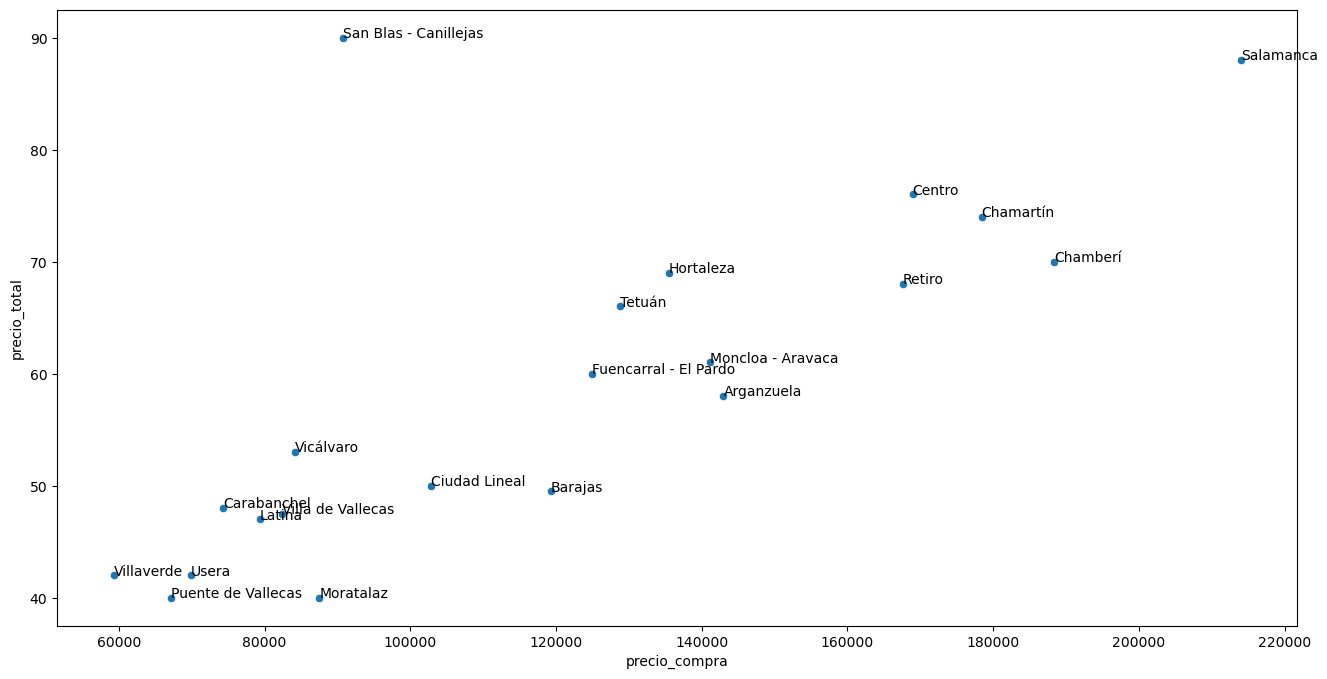

In [41]:
plt.figure(figsize=(16,8))
sns.scatterplot(data= temp, x= 'precio_compra', y ='precio_total')

for cada in range(0, temp.shape[0]):
    plt.text(temp.precio_compra[cada],temp.precio_total[cada], temp.index[cada]);

In [42]:
temp = df.groupby(['distrito','neighbourhood'])[['precio_total', 'precio_compra']].median()

In [43]:
temp

precio_total  precio_compra
distrito   neighbourhood                             
Arganzuela Acacias                53.8       142975.0
           Atocha                 60.0       142975.0
           Chopera                58.0       142975.0
           Delicias               55.0       142975.0
           Imperial               54.5       142975.0
...                                ...            ...
Villaverde Butarque               52.5        59255.0
           Los Angeles            37.5        59255.0
           Los Rosales            39.0        59255.0
           San Andrés             47.0        59255.0
           San Cristobal          42.0        59255.0

[128 rows x 2 columns]

In [44]:
temp.index[0][1]

'Acacias'

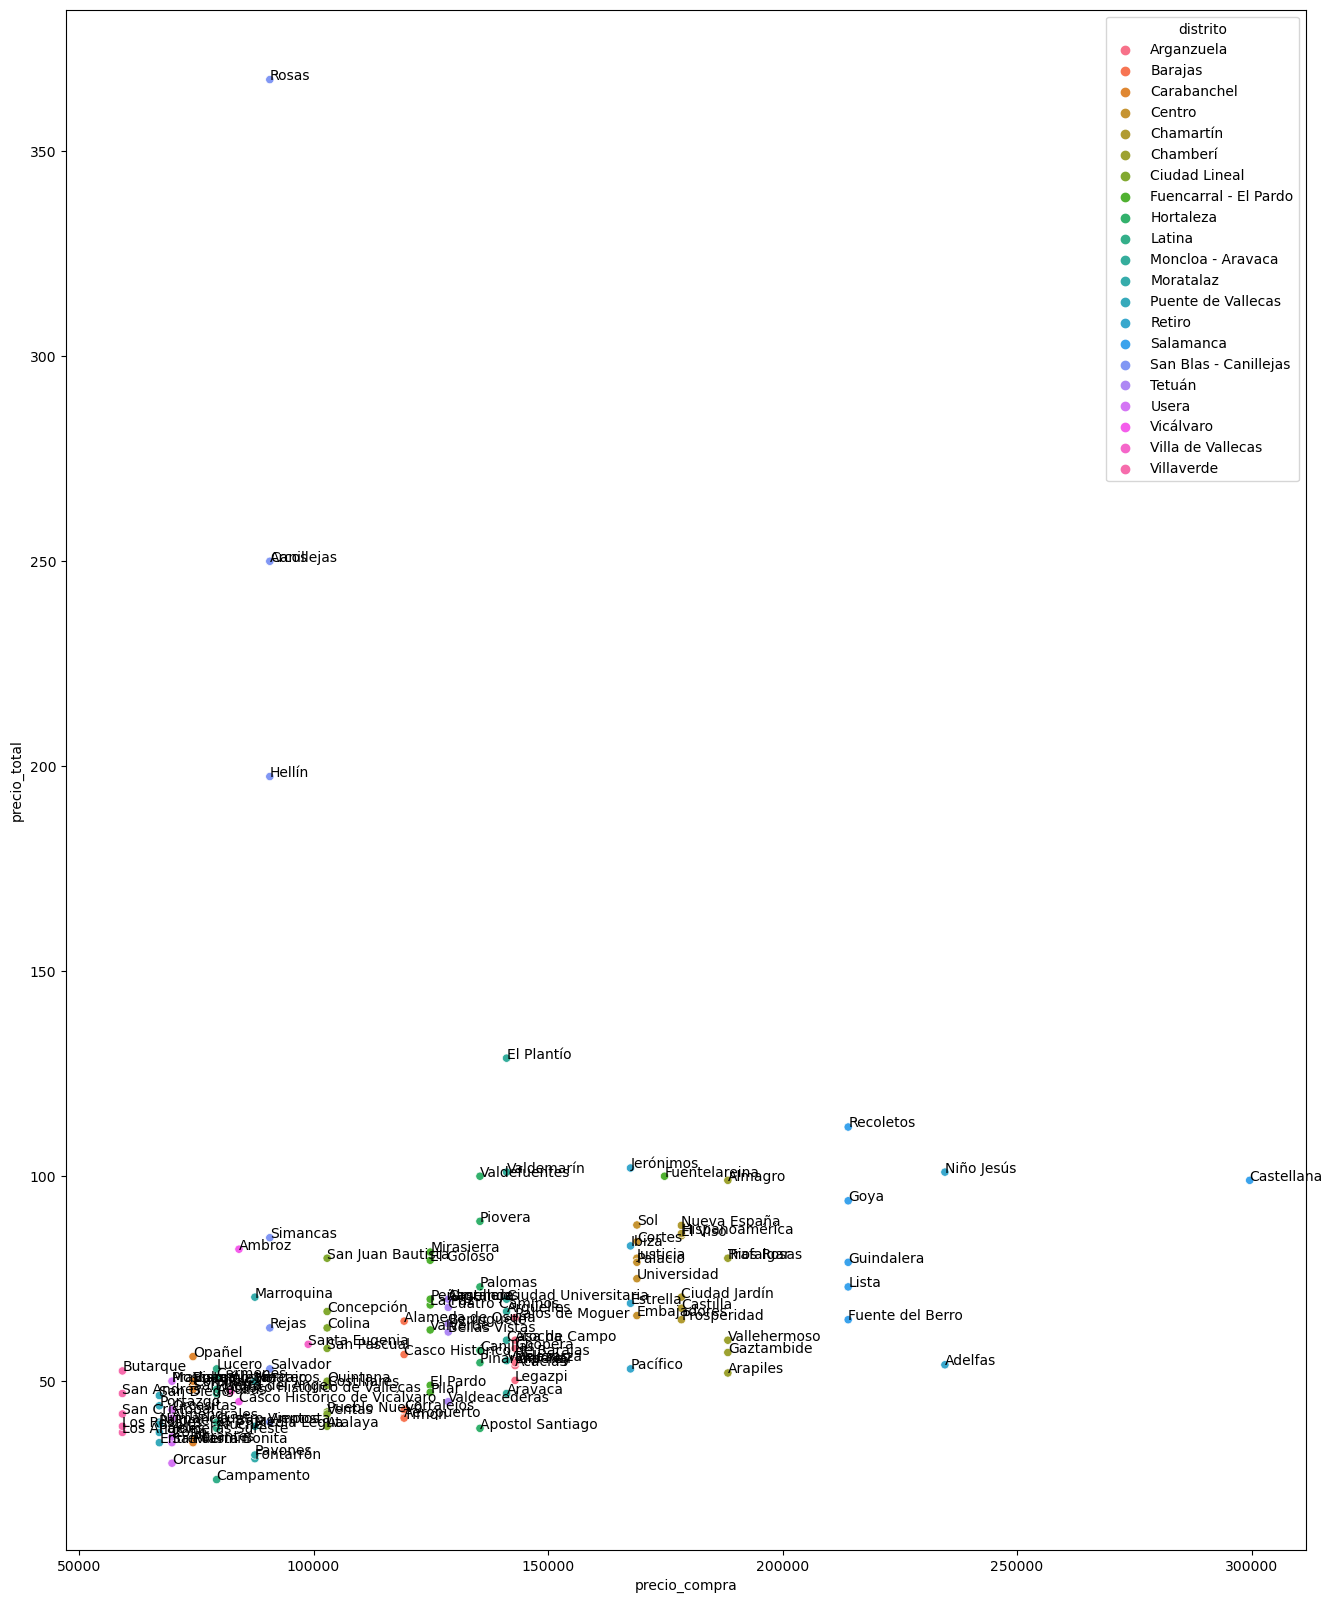

In [45]:
plt.figure(figsize=(16,20))
sns.scatterplot(data= temp, x= 'precio_compra', y ='precio_total', hue= 'distrito')

for cada in range(0, temp.shape[0]):
    plt.text(temp.precio_compra[cada],temp.precio_total[cada], temp.index[cada][1]);

A este nivel ya vemos más cosas:

* 3 barrios que sobresalen, posiblemente los 3 sean de San Blas
* Dentro de cada grupo de bajo-medio-alto sí podemos empezar a separarar
    * Bajo: Simancas, Ambroz, Marroquina, San Juan Bautista
    * Medio: El Plantio, Valdemarín, Valdefuentes
    * Medio-alto: Jerónimos, Fuentela reina
    * Alto: Recoletos
    
**Insight 2: Existen ciertos barrios que apriori pueden maximizar la relación coste-ingresos y además podemos segmentarlo por el tipo calidad del inmueble en el que nos interes invertir**

**¿Qué factores (a parte de la localización determinan el precio del alquiler?**

Para responder a esta pregunta podemos construir un minicubo, ya que hemos discretizado nuestras variables de análisis.

In [55]:
metricas = ['precio_total','precio_compra']
dimensiones = ['bedrooms_disc','accommodates_disc','beds_disc']

mini_cubo_precio = df[dimensiones + metricas]
mini_cubo_precio

,bedrooms_disc,accommodates_disc,beds_disc,precio_total,precio_compra
0,01_Una,0-3,2,60.0,178430.0
1,01_Una,0-3,2,31.0,79345.0
2,03_Tres,5-16,3-24,50.0,257355.0
3,01_Una,0-3,2,92.0,168945.0
4,01_Una,0-3,2,26.0,142975.0
...,...,...,...,...,...
17705,01_Una,0-3,2,29.0,168945.0
17706,01_Una,0-3,2,29.0,168945.0
17707,01_Una,0-3,2,29.0,168945.0
17708,01_Una,0-3,2,29.0,213990.0


In [56]:
mini_cubo_precio = mini_cubo_precio.melt(id_vars=['precio_total','precio_compra'])
mini_cubo_precio

,precio_total,precio_compra,variable,value
0,60.0,178430.0,bedrooms_disc,01_Una
1,31.0,79345.0,bedrooms_disc,01_Una
2,50.0,257355.0,bedrooms_disc,03_Tres
3,92.0,168945.0,bedrooms_disc,01_Una
4,26.0,142975.0,bedrooms_disc,01_Una
...,...,...,...,...
53125,29.0,168945.0,beds_disc,2
53126,29.0,168945.0,beds_disc,2
53127,29.0,168945.0,beds_disc,2
53128,29.0,213990.0,beds_disc,2


In [61]:
mini_cubo_precio = mini_cubo_precio.groupby(['variable','value'])[['precio_total','precio_compra']].agg('median')
mini_cubo_precio

precio_total  precio_compra
variable          value                                       
accommodates_disc 0-3                      50.0       168945.0
                  4                        86.0       168945.0
                  5-16                    126.0       236523.0
bedrooms_disc     01_Una                   56.0       168945.0
                  02_Dos                  100.0       236523.0
                  03_Tres                 140.0       304101.0
                  04_Cuatro_o_mas         204.0       405468.0
beds_disc         2                        59.0       168945.0
                  3                       100.0       236523.0
                  3-24                    139.0       257355.0

In [62]:
mini_cubo_precio.loc['bedrooms_disc']

,precio_total,precio_compra
value,,
01_Una,56.0,168945.0
02_Dos,100.0,236523.0
03_Tres,140.0,304101.0
04_Cuatro_o_mas,204.0,405468.0


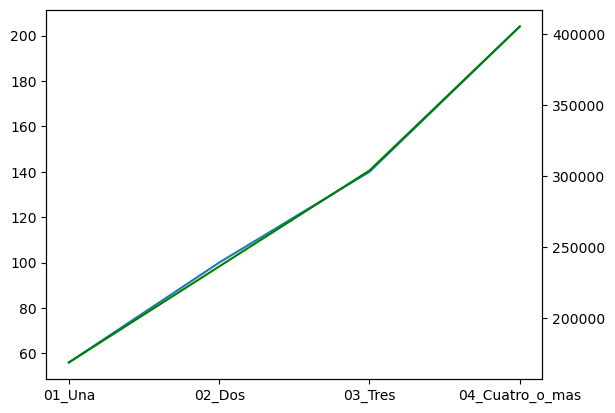

In [70]:
f, ax = plt.subplots()
ax.plot(mini_cubo_precio.loc['bedrooms_disc'].precio_total)
ax2 = ax.twinx()
ax2.plot(mini_cubo_precio.loc['bedrooms_disc'].precio_compra, color = 'green')

In [71]:
mini_cubo_precio.loc['beds_disc']

,precio_total,precio_compra
value,,
2,59.0,168945.0
3,100.0,236523.0
3-24,139.0,257355.0


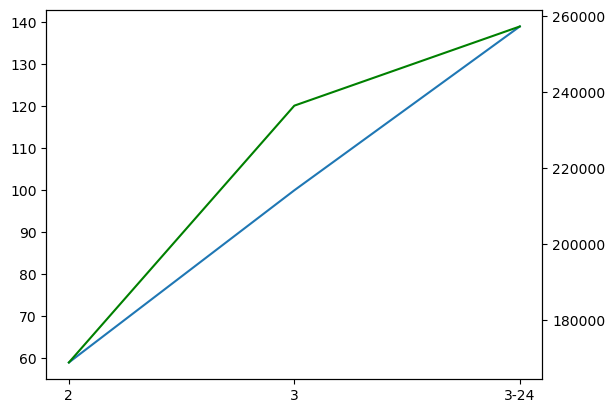

In [72]:
f, ax = plt.subplots()
ax.plot(mini_cubo_precio.loc['beds_disc'].precio_total)
ax2 = ax.twinx()
ax2.plot(mini_cubo_precio.loc['beds_disc'].precio_compra, color = 'green')

<AxesSubplot:xlabel='beds'>

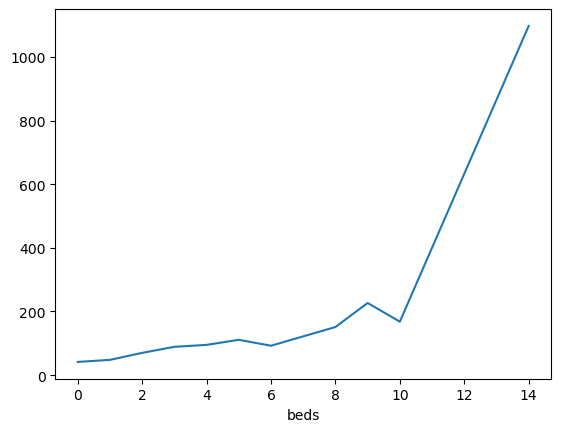

In [75]:
df[df.bedrooms == 1].groupby('beds').precio_total.median().plot()

In [76]:
mini_cubo_precio.loc['accommodates_disc']

,precio_total,precio_compra
value,,
0-3,50.0,168945.0
4,86.0,168945.0
5-16,126.0,236523.0


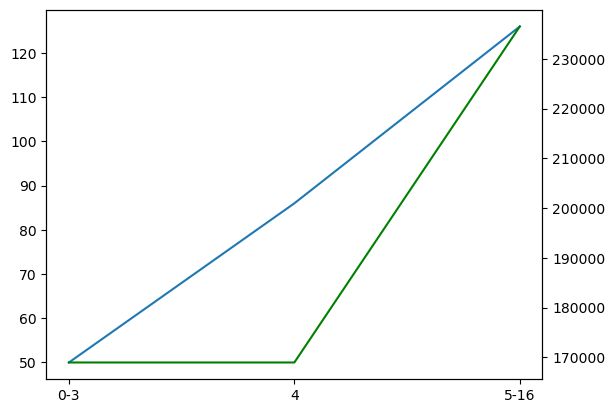

In [78]:
f, ax = plt.subplots()
ax.plot(mini_cubo_precio.loc['accommodates_disc'].precio_total)
ax2 = ax.twinx()
ax2.plot(mini_cubo_precio.loc['accommodates_disc'].precio_compra, color = 'green')

In [79]:
df.groupby('distrito').pdi_sol.median().sort_values()

distrito
Centro                    0.728581
Arganzuela                1.817840
Chamberí                  2.078790
Moncloa - Aravaca         2.130135
Retiro                    2.415432
Salamanca                 2.705209
Latina                    3.496952
Carabanchel               3.647956
Usera                     3.661376
Chamartín                 4.233216
Puente de Vallecas        4.233631
Tetuán                    4.572866
Ciudad Lineal             5.170226
Moratalaz                 5.242395
Villaverde                7.579665
Fuencarral - El Pardo     7.738933
San Blas - Canillejas     7.962141
Hortaleza                 8.132864
Vicálvaro                 8.396723
Villa de Vallecas         8.822907
Barajas                  11.593340
Name: pdi_sol, dtype: float64

In [83]:
seleccion = df.groupby('distrito').pdi_sol.median().sort_values()[:7].index.to_list()

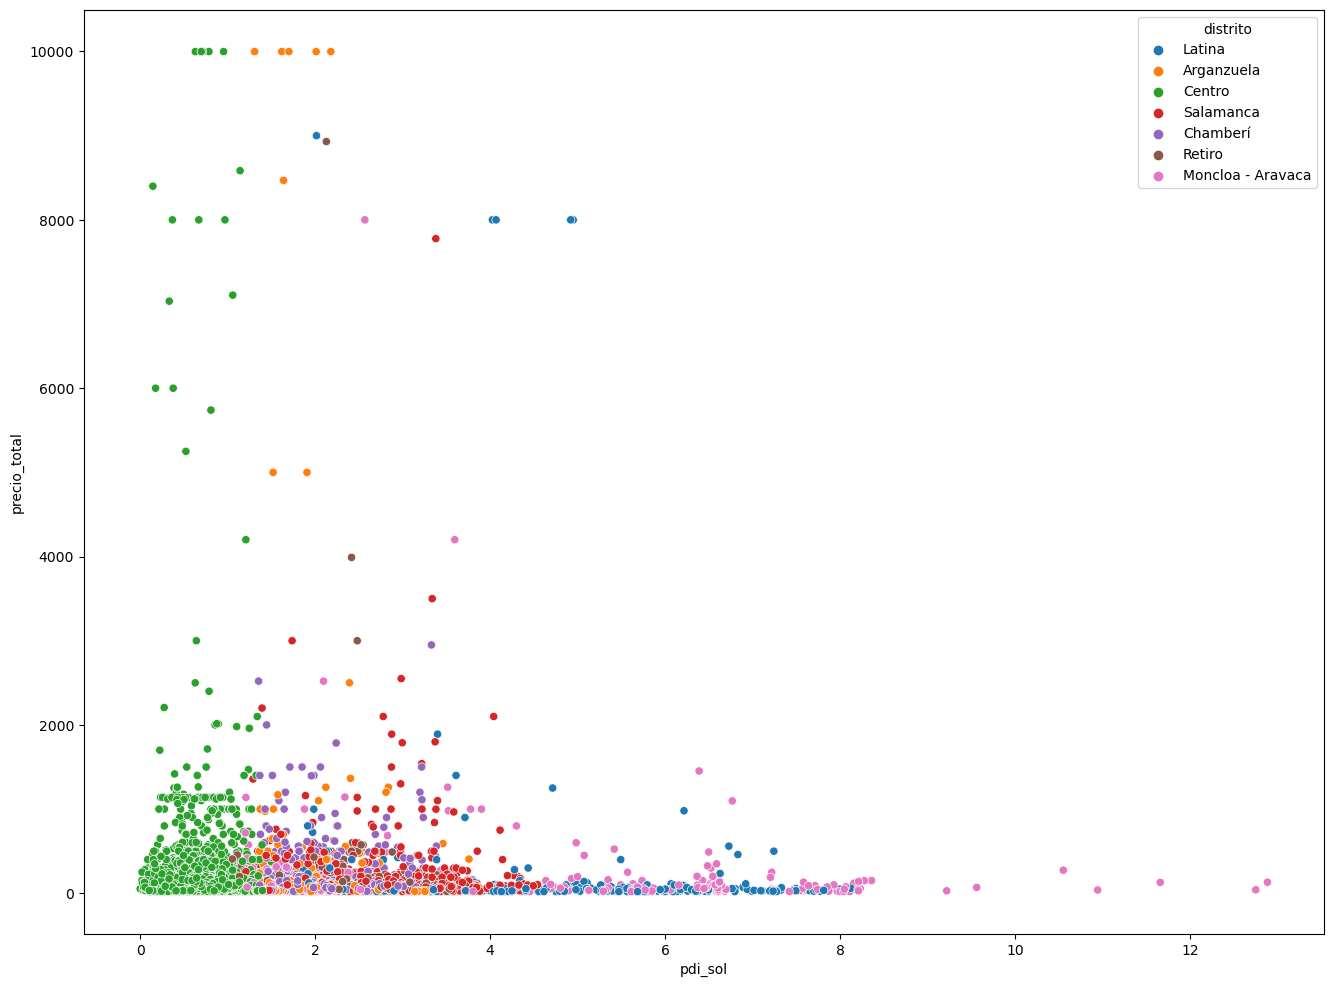

In [88]:
plt.figure(figsize=(16,12))
sns.scatterplot(data = df.loc[df.distrito.isin(seleccion)], x='pdi_sol', y='precio_total', hue= 'distrito');

### Analisis sobre la ocupación

In [89]:
import folium

In [107]:
datos = df[df.distrito == 'San Blas - Canillejas'].copy()
datosbb

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,distrito,precio_total,ocupacion,bedrooms_disc,accommodates_disc,beds_disc,number_of_reviews_disc,m2,precio_compra,pdi_sol
141,141,479718,Wanda Stadium. Madrid. 20 minutes from Sol by tube,2376402,San Blas - Canillejas,Rosas,40.432020,-3.603530,Private room,36,...,San Blas - Canillejas,36.0,69,01_Una,0-3,2,6-49,50,90685.0,8.620512
152,152,518208,LOVELY ORANGE ROOM & NEAR WANDA´S STAADIUM,2536524,San Blas - Canillejas,Arcos,40.427560,-3.615770,Private room,21,...,San Blas - Canillejas,29.4,27,01_Una,0-3,2,6-49,50,90685.0,7.512148
247,247,755535,LOVELY ROOM & NEAR WANDA´S STADIUM,2536524,San Blas - Canillejas,Arcos,40.427610,-3.615800,Private room,21,...,San Blas - Canillejas,29.4,99,01_Una,0-3,2,6-49,50,90685.0,7.510532
250,250,758670,LOVELY ROOM & NEAR WANDA´S STADIUM,2536524,San Blas - Canillejas,Arcos,40.426700,-3.616310,Private room,21,...,San Blas - Canillejas,21.0,28,01_Una,0-3,2,6-49,50,90685.0,7.452229
253,253,761095,Compostela Suites Madrid Airport / 2BD,4012305,San Blas - Canillejas,Rejas,40.447910,-3.579180,Entire home/apt,85,...,San Blas - Canillejas,85.0,0,02_Dos,0-3,2,6-49,70,126959.0,11.068977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17339,17339,51602462,🌟Habitación Wanda,11769281,San Blas - Canillejas,Canillejas,40.436886,-3.608566,Private room,32,...,San Blas - Canillejas,32.0,7,01_Una,0-3,2,5,50,90685.0,8.331702
17554,17554,51906548,"Loft Deluxe , apartamento oficina , Ciudad Lineal",54623373,San Blas - Canillejas,Simancas,40.434867,-3.633209,Entire home/apt,45,...,San Blas - Canillejas,45.0,7,01_Una,4,2,5,50,90685.0,6.271326
17628,17628,52083353,🌟 Habitación cerca del aeropuerto,11769281,San Blas - Canillejas,Canillejas,40.436899,-3.611810,Private room,29,...,San Blas - Canillejas,29.0,0,01_Una,0-3,2,5,50,90685.0,8.067943
17634,17634,52089835,Pequeña pero confortable,304292190,San Blas - Canillejas,Rosas,40.426300,-3.609220,Private room,23,...,San Blas - Canillejas,23.0,0,01_Una,0-3,2,5,50,90685.0,8.040401


In [116]:
mapa = folium.Map(location=[40.167278,-3.7533387], zoom_start= 12)

for piso in range(0,len(datos)):
    folium.Marker(                
                location = [datos.iloc[piso]['latitude'], datos.iloc[piso]['longitude']],
                popup = datos.iloc[piso]['precio_total']).add_to(mapa)
mapa

In [119]:
#discretizamos el precio total

datos['precio_total_disc'] = pd.qcut(datos['precio_total'], q= [0, 0.25, 0.5, 0.75,1],
        labels = ['yellow', 'orange', 'blue', 'red'])

In [120]:
mapa = folium.Map(location=[40.167278,-3.7533387], zoom_start= 12)

for piso in range(0,len(datos)):
    folium.CircleMarker(                
                location = [datos.iloc[piso]['latitude'], datos.iloc[piso]['longitude']],
                popup = datos.iloc[piso]['precio_total'],
                fill = True,
                color = datos.iloc[piso]['precio_total_disc'],
                fill_opacity= 1,
                radius = 5).add_to(mapa)
mapa